# Salary Prediction Model Report

## Table of Contents

1. [Introduction](#introduction)  
2. [Project Setup & Kedro Context](#setup)  
3. [Data Overview](#data-overview)  
   - 3.1. [Raw Datasets](#raw-datasets)  
   - 3.2. [Target Variable](#target-variable)  
   - 3.3. [Missing Data & Quality Checks](#missing-data)  
4. [Preprocessing & Feature Engineering](#feature-engineering)  
   - 4.1. [Preprocessing Versions](#preprocessing-versions)    
5. [Modeling Approach](#modeling-approach)  
   - 5.1. [Baseline & Linear Models](#baseline-linear)  
   - 5.2. [Regularized Models (Lasso, ElasticNet)](#regularized-models)  
   - 5.3. [Tree-Based Models (RF, XGBoost)](#tree-models)  
   - 5.4. [Hyperparameter Optimization](#hyperparameter-optimization)  
   - 5.5. [SHAP-Based Feature Selection](#shap-selection)  
6. [Model Evaluation](#evaluation)  
   - 6.1. [Evaluation Metrics](#metrics-explained)  
   - 6.2. [Confidence Intervals](#confidence-intervals)  
   - 6.3. [Performance Comparison Table](#comparison-table)  
   - 6.4. [Performance Visualization](#comparison-plot)  
7. [Best Model Deep Dive](#best-model)  
   - 7.1. [Feature Importance (SHAP)](#feature-importance)  
   - 7.2. [Residual Analysis](#residual-analysis)  
8. [Conclusion & Next Steps](#conclusion)  

## 1. Introduction

This project was developed as part of a technical challenge. The goal is to design, implement, and evaluate a machine learning model capable of predicting an individual's salary based on structured features provided in a public dataset.

The dataset includes the following columns:
- Age
- Gender
- Education level
- Job title
- Years of experience
- Description (free-text field)

The predictive task is to estimate the salary from these features, using Python-based tools and best practices in modular code development.

### Challenge Goals

The technical requirements for the challenge included:
- Developing a predictive model with a clean and modular Python codebase
- Applying preprocessing and feature transformations
- Evaluating model performance using appropriate metrics and confidence intervals
- Including a clear comparison with a sensible baseline (e.g., DummyRegressor)
- Presenting final results in a well-documented Jupyter Notebook
- Hosting the solution in a public GitHub repository

### Project Design Overview

To address the challenge in a structured and scalable way, this project was implemented using **[Kedro](https://kedro.org/)** — a Python framework for reproducible, modular data science workflows.

The core of this project is divided into:
1. **Preprocessing Pipelines**: Structured in two alternative versions (v1 and v2) to experiment with different feature engineering strategies.
2. **Modeling Pipeline**: Trains and evaluates a wide range of regressors, including baseline, linear, regularized, and tree-based models.
3. **Reporting Pipeline**: Aggregates and visualizes model performance, selects top models, and explains results using tools like SHAP.

Although the dataset includes a free-text `description` field, it was **intentionally excluded** from the modeling process in this version, to focus on structured features and simplify the development pipeline.


## 2. Project Setup & Kedro Context

This project follows a modular structure using **Kedro**, which organizes code into independent pipelines for data preprocessing, modeling, and reporting.

The directory structure includes:
- `src/salary_prediction/pipelines/data_processing`: Data cleaning, splitting, and feature engineering (v1 and v2)
- `src/salary_prediction/pipelines/data_science`: Model training, hyperparameter optimization, SHAP analysis
- `src/salary_prediction/pipelines/reporting`: Visualization, model comparison, and selection

Kedro allows us to:
- Run partial pipelines with version control
- Pass parameters via `parameters.yml`
- Use a `DataCatalog` to manage datasets cleanly




In [48]:
# Load the Kedro context so we can interact with the pipelines and datasets from within the notebook.
from pathlib import Path
from kedro.framework.hooks import _create_hook_manager
from kedro.framework.project import configure_project
from kedro.framework.context import KedroContext
from kedro.config import OmegaConfigLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Set up Kedro project context
project_path = Path.cwd().parents[0]  # If your notebook is in ./notebooks
configure_project("salary_prediction")

conf_path = project_path / "conf"
env = "local"
config_loader = OmegaConfigLoader(conf_source=str(conf_path))
hook_manager = _create_hook_manager()

context = KedroContext(
    package_name="salary_prediction",
    project_path=project_path,
    config_loader=config_loader,
    hook_manager=hook_manager,
    env=env,
)

catalog = context.catalog
print("Kedro context initialized successfully.")

Kedro context initialized successfully.


## 3. Data Overview

**Note: A detailed Exploratory Data Analysis (EDA) was conducted in a separate notebook (`notebooks/01_EDA.ipynb`). In the EDA, we explored the structure and quality of the datasets, identified missing values, and analyzed the distribution and relationships of key features with salary. We found strong correlations with age, experience, and education, grouped job titles for better modeling, and tested feature interactions. Random Forest models benefited most from including all engineered features and interactions.**


The original dataset includes records for individuals with the following fields:

- `Age`
- `Gender`
- `Education Level`
- `Job Title`
- `Years of Experience`
- `Description` (free text)
- `Salary` (target)

In this challenge, we chose to **exclude the `Description` field** to focus solely on structured features. Future iterations could experiment with NLP techniques to incorporate this field.

### 3.1. Raw Datasets

Dataset composition:
- Total number of samples: 375
- Salary dataset: 375 rows, 2 columns (id, Salary)
- People dataset: 375 rows, 6 columns (id, Age, Gender, Education Level, Job Title, Years of Experience)

Education Levels:
- Bachelor's: 222 samples
- Master's: 97 samples
- PhD: 51 samples

Job Titles:
- Diverse range of job titles (50+ unique titles)
- Top job titles include:
  - Director of Marketing (12 samples)
  - Director of Operations (10 samples)

Additional Features:
- Age: Numeric value indicating age
- Gender: Male and Female
- Years of Experience: Numeric value indicating years of working experience




In [49]:
catalog.load("salary_raw").info()

[04/16/25 00:38:04] INFO     Loading data from salary_raw (CSVDataset)...                       ]8;id=807052;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=707229;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      375 non-null    int64  
 1   Salary  373 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.0 KB


In [50]:
catalog.load("people_raw").info()

                    INFO     Loading data from people_raw (CSVDataset)...                       ]8;id=443970;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=401317;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   375 non-null    int64  
 1   Age                  370 non-null    float64
 2   Gender               370 non-null    object 
 3   Education Level      370 non-null    object 
 4   Job Title            370 non-null    object 
 5   Years of Experience  373 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.7+ KB


### 3.2. Target Variable

Salary Distribution:
- Total valid salary entries: 373 (2 null values)
- Mean Salary: $100,577
- Median Salary: $95,000
- Salary Range: $350 - $250,000
- Standard Deviation: $48,240


In [51]:
salary_raw = catalog.load("salary_raw")
salary_raw.describe()

                    INFO     Loading data from salary_raw (CSVDataset)...                       ]8;id=321709;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=614752;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

,id,Salary
count,375.000000,373.000000
mean,187.000000,100577.345845
std,108.397417,48240.013482
min,0.000000,350.000000
25%,93.500000,55000.000000
50%,187.000000,95000.000000
75%,280.500000,140000.000000
max,374.000000,250000.000000


                    INFO     Loading data from salary_raw (CSVDataset)...                       ]8;id=470478;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=449020;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

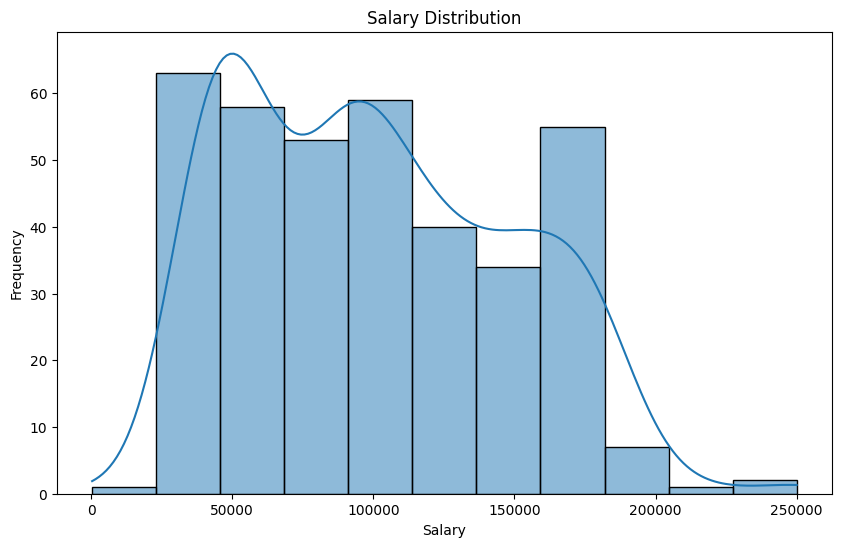

Skewness: 0.400578053273342


In [52]:
# Distribution of the target variable
salary_raw = catalog.load("salary_raw")
plt.figure(figsize=(10, 6))
sns.histplot(salary_raw['Salary'], kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

print(f"Skewness: {salary_raw['Salary'].skew()}")

**The distribution is slightly right-skewed. Salary tend to be clustered towards the lower end. Seems to not be skewed enough to necessarily require transformation.**

### 3.3. Missing Data & Quality Checks
Missing Data in Salary Dataset:
- Total samples: 375
- Valid salary entries: 373
- Missing salary entries: 2 (0.53% of the dataset)
- Note from EDA: "Two null salary -> Remove in the data processing steps"

Missing Data in People Dataset:
- Education Level: Contains nan values
- Total samples: 375
- Bachelor's: 222
- Master's: 97
- PhD: 51
- Unspecified/Missing: Some nan entries present

Missing Data in Job Title:
- Job Title column also contains nan entries
- Multiple unique job titles (50+ different titles)
- Some job titles have missing values

Data Quality Observations:
- Consistent id column across datasets
- Salary range: $350 - $250,000
- Salary has a standard deviation of $48,240
- Age and Years of Experience have nans

**Review the `notebooks/01_EDA.ipynb` notebook with the exploratory data analysis**

## 4. Preprocessing & Feature Engineering

To ensure consistent and high-quality inputs for modeling, the project defines two alternative preprocessing pipelines. Both pipelines share a common initial preprocessing stage followed by a versioned transformation step, enabling experimentation with multiple feature engineering strategies.

### Common Preprocessing Steps

All preprocessing versions begin with a shared set of operations:
- Merging datasets: The people and salary datasets are joined on the 'id' column.
- Cleaning: Duplicate rows are removed and entries with missing target values are dropped.
- Train-test split: Features and target are separated, and the data is split, with a configurable random seed for reproducibility.

### Preprocessing Pipelines
Two distinct pipelines are defined for transforming features:

- Version 1: Basic Pipeline. This pipeline serves as a baseline with minimal transformation logic to retain interpretability and test model robustness on less processed features.
  - Missing value imputation:
    - Numerical columns: median strategy.
    - Categorical columns: most frequent value.
  - Encoding:
    - Low-cardinality categorical features: One-Hot Encoding (with drop="first" to avoid multicollinearity).
    - High-cardinality features: encoded using Ordinal Encoding (with unknown_value=-1 to handle unseen categories).
  - All numerical features are scaled using StandardScaler (zero mean, unit variance).

   
- Version 2: Enhanced Pipeline. This version introduces more advanced feature engineering techniques to enrich the dataset with domain-specific transformations and improved encoding strategies
  - Job Title Grouping: Job titles are categorized into hierarchical groups based on both seniority (e.g., Junior, Senior, Executive) and department (e.g., Technical, HR, Marketing). This new JobTitleGroup feature replaces the original raw title to reduce cardinality while preserving semantic meaning.
  - Optional interaction features (configurable via parameters):
    - Age × Years of Experience: Captures non-linear relationships between maturity and experience.
    - Education Level × Years of Experience: Combines formal education with practical experience using an ordinal mapping.
  - Missing value imputation:
    - Numerical columns: imputed using the median.
    - Categorical columns (including grouped job titles and education): imputed using the most frequent value.
  - Encoding:
    - Education Level: encoded using Ordinal Encoding with a predefined hierarchy (e.g., Bachelor's < Master's < PhD).
    - Grouped job titles and low-cardinality features: encoded using One-Hot Encoding (with drop="first" to avoid redundancy).
  - Feature scaling:
    - All numerical features are scaled using StandardScaler (zero mean, unit variance).


In [53]:
catalog.load("X_train_preprocessed_v2").head()

                    INFO     Loading data from X_train_preprocessed_v2 (ParquetDataset)...      ]8;id=79141;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=999783;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

,Age,Years of Experience,Age_x_Years of Experience,Education Level,JobTitleGroup_Executive_Finance,JobTitleGroup_Executive_HR,JobTitleGroup_Executive_Marketing,JobTitleGroup_Executive_Operations,JobTitleGroup_Executive_Other,JobTitleGroup_Executive_Product,...,JobTitleGroup_Senior_HR,JobTitleGroup_Senior_Marketing,JobTitleGroup_Senior_Operations,JobTitleGroup_Senior_Other,JobTitleGroup_Senior_Product,JobTitleGroup_Senior_Sales,JobTitleGroup_Senior_Technical,JobTitleGroup_Unknown,Gender_Male,Gender_None
193,-0.493751,-0.469123,-0.556112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
75,-0.066439,-0.007995,-0.154897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
84,-1.205939,-1.237669,-1.103222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,-0.636189,-0.776541,-0.777996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16,-0.636189,-0.469123,-0.577388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Modeling Approach

This section details the various regression models developed to predict salaries based on two preprocessing versions (v1 and v2). Models span from simple baselines to complex tree-based ensembles, including hyperparameter tuning and feature selection strategies.

### 5.1. Baseline & Linear Models
To establish a performance benchmark, a DummyRegressor was used, which predicts the mean salary regardless of input. This sets the lower bound for model performance.

Subsequently, a Linear Regression model was trained on the preprocessed features. This model serves as a simple yet interpretable baseline leveraging all numeric and encoded categorical variables without regularization.

All models in this group were evaluated using cross-validation and tested on both preprocessed datasets.

### 5.2. Regularized Models (Lasso, ElasticNet)
To address multicollinearity and enhance generalization, two regularized linear models were employed:

 - Lasso Regression: L1-penalized regression that performs variable selection by shrinking some coefficients to zero.
 - ElasticNet Regression: Combines L1 and L2 penalties, balancing between feature selection and coefficient shrinkage.

Both models were trained on v2-preprocessed data. Additionally, ElasticNet was further optimized via Optuna to search for the best alpha and l1_ratio values. This resulted in an "ElasticNet Optimized" model.

Each variant was evaluated using cross-validation with confidence intervals computed for MSE, RMSE, and R².

### 5.3. Tree-Based Models (RF, XGBoost)
To capture non-linear relationships and feature interactions, tree-based regressors were trained:

- Random Forest Regressor:
  - Trained using both v1 and v2 pipelines.
  - Further enhanced with Optuna-based hyperparameter tuning.

- XGBoost Regressor:
  - Trained only on the v2-preprocessed data.
  - Hyperparameters such as n_estimators, max_depth, and learning_rate were optimized using Optuna.

All tree-based models were evaluated using stratified cross-validation, and performance metrics include both point estimates and 95% confidence intervals.

### 5.4. Hyperparameter Optimization
For selected models (ElasticNet, RandomForest, and XGBoost), hyperparameters were tuned using Optuna's TPE sampler. Trials optimized for negative mean squared error (MSE) using cross-validation, with reproducibility enforced via fixed random seeds.

Each study reported the best hyperparameter set and corresponding CV score. These optimized models were compared against their default versions to assess gains in performance and stability.

### 5.5. SHAP-Based Feature Selection
To explore explainability and reduce feature dimensionality:

A Random Forest model was trained on v2-preprocessed data.
 - SHAP (SHapley Additive exPlanations) values were computed to assess feature importance.
 - Features were selected based on importance (either threshold or top-n selection, as configured).
 - A new Random Forest model was then trained on the SHAP-selected subset.

This variant was also evaluated using cross-validation, with metrics and confidence intervals reported to gauge performance relative to the full-feature RF model.

In [54]:
catalog.load("randomforestregressor_model_v2")


                    INFO     Loading data from randomforestregressor_model_v2                   ]8;id=540963;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=877309;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\
                             (PickleDataset)...                                                                    

RandomForestRegressor(max_depth=5, random_state=3)

## 6. Model Evaluation

Each model was evaluated using the following metrics:

- **RMSE**: Root Mean Squared Error – sensitive to large errors
- **R² Score**: Proportion of variance explained by the model

All metrics are reported as **confidence intervals**, using bootstrapped cross-validation.
